# Grover's search algorithm
Grover's search algorithm is one of the more straightforward quantum algorithms for solving an actual problem using quantum computing, namely finding information in an indexed but unsorted database.  Grover is expected to be quadratically faster than its classical counterpart. 

This exercise is losely based on the [Grover's algorithm and its Qiskit implementation Qiskit tutorial](https://quantum-computing.ibm.com/support/guides/quantum-algorithms-with-qiskit?page=5cc0d9fd86b50d00642353ca#experiment-with-simulators), which goes inte greater detail regarding the implementation and theory.

A good read on understanding Grover, from Scott Aaronson: https://www.scottaaronson.com/qclec/22.pdf

What we will demonstrate is an unstructured search of a database, using the so called amplitude magnification trick.

Let's start by importing the required methods.

In [ ]:
# Importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy

# Import basic plot tools
from qiskit.tools.visualization import plot_histogram

# Qiskit Terra Grover implementation
In Qiskit terra we can create a Grover implementation using for example a phase oracle, which in combination with a phase ... inversion about average increases the amplitude of the "correct" answer according to the oracle.

With the Grover algorithm we create a so called oracle function, which is designed to take as input a set of qubits in initial superposition, and switch the phase of the correct answer (|$\psi$>) by 2$\pi$, while leaving the phase of the incorrect answers alone. The oracle can identify the correct answer if you feed it that answer. It cnnot calculate a correct answer. 

The Grover unitary matrix is essentially a diagonal matrix containing ones, with a negative one that represents the solution, and will switch the phase for the corresponding state. This unitary matrix can be realized using standard gates in a quantum circuit. For a look at an example oracle unitary, see the 'Taking a look at the Grover circuit, step-by-step' section at the end of the Notebook.

In the examples below, the two-qubit Toffoli gate (CCX) serves as a controlled phase shift gate (HXH = Z) that shifts the phase of the state by by 2$\pi$ (-1) if the value of the three qubits match the correct answer. 



## Examples

Oracle for: |100>
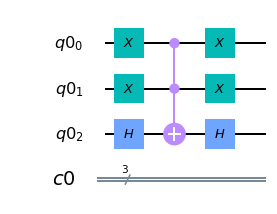

Oracle for: |111>

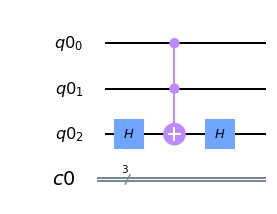

For this exercise we created a 3-qubit Oracle circuit for the |100> oracle that we can then add to our Grover circuit.

In [ ]:
# Let's create the oracle circuit for the |100> state as the correct answer.

qr = QuantumRegister(3)
cr = ClassicalRegister(3)
oracleCircuit=QuantumCircuit(qr,cr)


oracle_type="|100>"
oracleCircuit.x(qr[0])
oracleCircuit.x(qr[1])
oracleCircuit.h(qr[2])
oracleCircuit.ccx(qr[0],qr[1],qr[2])
oracleCircuit.x(qr[1])
oracleCircuit.h(qr[2]) 
oracleCircuit.x(qr[0]) 

display(oracleCircuit.draw(output="mpl"))


The next step in the Grover method is to create an amplifier circuit that takes the incoming states and amplifies the phase that corresponds to the correct answer by 'mirroring' it across the average amplitude. Again, this can be represented as a unitary matrix where. For a look at an example amplifier unitary, see the 'Taking a look at the Grover circuit, step-by-step' section at the end of the Notebook.

In [ ]:
# Let's create the amplifier circuit for three qubits.

amplifierCircuit=QuantumCircuit(qr,cr)

amplifierCircuit.barrier(qr)
amplifierCircuit.h(qr)
amplifierCircuit.x(qr)
amplifierCircuit.h(qr[2])
amplifierCircuit.ccx(qr[0],qr[1],qr[2])
amplifierCircuit.h(qr[2])
amplifierCircuit.barrier(qr)
amplifierCircuit.x(qr)
amplifierCircuit.h(qr)

display(amplifierCircuit.draw(output="mpl"))

Now, let's create the quantum circuit that will enclose our oracle and amplifier, add some measurement gates and give it a whirl.

In [ ]:
groverCircuit = QuantumCircuit(qr,cr)

# Initiate the Grover with Hadamards
groverCircuit.h(qr)
groverCircuit.barrier(qr)

# Add the oracle and the inversion
groverCircuit+=oracleCircuit
groverCircuit+=amplifierCircuit

# Add measurements
groverCircuit.measure(qr,cr)
print("Grover circuit for:", oracle_type)
groverCircuit.draw(output="mpl")

Finally, let us run the Grover circuit on the qasm simulator to see if it finds the correct solution.

In [ ]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
print("Oracle for: ", oracle_type)
display(plot_histogram(answer))

**Now it is your turn!** Modify the code in the oracleCircuit box above to create a different Oracle, such as the other example from above: `|111>`. When you have successfully run that circuit and gotten the expected results, try adding a second set of oracleCircuit and amplifierCircuit to set up two iterations instead of one. Does that make a difference in the end results. How about three iterations? More?

**For the really curious!** See if you can create the oracleCircuit for the following oracles: `|000>` and `|010>`

# Qiskit Aqua Grover algorithm

Grover comes built-in with Qiskit Aqua. With Aqua you can use two input types to define the oracle: `LogicalExpressionOracle` and `TruthTableOracle`.

An example of a logical expression oracle for the `|100>` oracle above, with the least significant bit (LSB) to the left in the logic:
```
'(A & ~B & ~C)'
```
When you use truth table input you create a bit-string that represents the expected output for the oracle. For the `|100>` example, this bit string is:
```
'00001000'
```

In [ ]:
# Do the necessary import for our program
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from qiskit.compiler import transpile

We can now set the oracle method that we want to use, and then provide the logical expression and bitstring.

In [ ]:
# set the oracle method: "Log" for logical expression or "Bit" for bit string. 
oracle_method = "Log" 

# set the input
log_expr = '(~A & ~B & C)' #<- Oracle for |001>
bitstr = '00001000'  

# build the circuit
if oracle_method=="Log":
    algorithm = Grover(LogicalExpressionOracle(log_expr))
    circuit = Grover(LogicalExpressionOracle(log_expr)).construct_circuit()
else:
    algorithm = Grover(TruthTableOracle(bitstr))
    circuit = Grover(TruthTableOracle(bitstr)).construct_circuit()

circuit.draw(output="mpl")

In [ ]:
# Run the algorithm on a simulator, printing the most frequently occurring result
backend = BasicAer.get_backend('qasm_simulator')

result = algorithm.run(backend)
print("Oracle for:", oracle_type)
print("Oracle method:",oracle_method)
print(result['top_measurement'])
plot_histogram(result['measurement'])

**Your turn!** Modify the logical expression and/or bitstring to realize the `|111>`, `|000>`, and `|010>` oracles from above. Do they produce the same probabilities as your gate circuit Grover? 

# Taking a look at the Grover circuit, step-by-step

Let's take a look at the behavior of our qubits as we walk through the circuit by viewing the unitary matrix for the oracle and amplifier circuits + the state vector in numeric form and with the Q Sphere.



In [ ]:
# Import visualization
from qiskit.visualization import plot_histogram, plot_bloch_multivector, iplot_bloch_multivector, plot_state_qsphere, iplot_state_qsphere

# Add the state vector calculation function
def get_psi(circuit, vis): 
    global psi
    backend = BasicAer.get_backend('statevector_simulator') 
    psi = execute(circuit, backend).result().get_statevector(circuit)
    if vis=="IQ":
        display(iplot_state_qsphere(psi))
    elif vis=="Q":
        display(plot_state_qsphere(psi))
    elif vis=="M":
        print(psi)
    elif vis=="B":
        display(plot_bloch_multivector(psi))
    else: # vis="IB"
        display(iplot_bloch_multivector(psi))
        
    vis=""

## Step 1: Create the circuit

Here we create the sircuit and prepare the qubits in a superposition state. The state vector and Q Sphere representions shows us eight possible outcomes with equal probability, as expected.

In [ ]:
groverVisCircuit = QuantumCircuit(qr,cr)

# initiate the Grover with Hadamards
groverVisCircuit.h(qr)
groverVisCircuit.barrier(qr)
display(groverVisCircuit.draw(output="mpl"))
get_psi(groverVisCircuit,"M")
get_psi(groverVisCircuit,"Q")

From the state vector, and from the Q Sphere, you can see that the initial circuit would give all possible results from |000> to |111> with equal probability of 12% (0.3535^2).

## Step 2: Run the oracle

In this step we run the oracle, which flips the oracle state $\pi$ radians from the other possible states. The flipping is done by the doubly-controlled Z-gate (H+CCX+H in the circuit below). The state vector and Q Sphere shows the opposite phase for the |001> state indicated by a minus sign for the state vector, and a phase colored vector for the Q Sphere. 

In [ ]:
# Add the oracle
groverVisCircuit+=oracleCircuit

display(groverVisCircuit.draw(output="mpl"))

# Choose unitary simulator
backend = BasicAer.get_backend('unitary_simulator') 
unit=execute(oracleCircuit, backend).result().get_unitary(oracleCircuit)
print("Oracle unitary matrix vector:\n")
print(unit.real)
print("State vector after oracle:\n")

get_psi(groverVisCircuit,"M")
get_psi(groverVisCircuit,"Q")

Now you can see that the outcome that matches the oracle (|100> has shifted phase. Notice the minus sign in the state vector, and the different color in the Q Sphere.

## Step 3: Phase amplification

Finally, we run the qubits through the phase amplification, where the prepared state is again amplified.

In [ ]:
# Add the amplifier
groverVisCircuit+=amplifierCircuit
display(groverVisCircuit.draw(output="mpl"))

# Choose unitary simulator
backend = BasicAer.get_backend('unitary_simulator') 
unit_amp=execute(amplifierCircuit, backend).result().get_unitary(amplifierCircuit)
print("Amplifier unitary matrix vector:\n")
print(unit_amp.real)
print("State vector after amplifier:\n")

get_psi(groverVisCircuit,"M")
get_psi(groverVisCircuit,"Q")

This last step produces some dramatic results. We have now reflected the state vectOrder s against the average, which has ballooned the correct answer, and shrunk the non-correct ones. You can see this in the state vection, and in the Q Sphere where one major correct state vector stands out among the incorrect ones.

## Bonus exercise: Run the oracle on a real quantum computer

Use your knowledge from the previous exercises to modify the execution steps in this exercise to run on an actual IBM Q backend.